# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

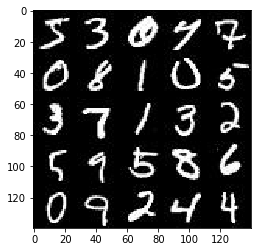

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

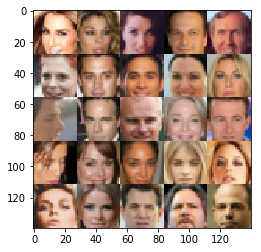

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0-rc2
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z    = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr         = tf.placeholder(tf.float32, (), name='learning_rate')

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    drop_rate = 0.5
    size_mult = 64
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.dropout(images, rate=drop_rate/2.5)
        
        x1 = tf.layers.conv2d(x, size_mult, 3, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.layers.dropout(relu1, rate=drop_rate)
        
        x2 = tf.layers.conv2d(relu1, size_mult, 3, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(relu2, size_mult, 3, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, rate=drop_rate)
        
        x4 = tf.layers.conv2d(relu3, 2 * size_mult, 3, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        x5 = tf.layers.conv2d(relu4, 2 * size_mult, 3, strides=1, padding='same')
        bn5 = tf.layers.batch_normalization(x5, training=True)
        relu5 = tf.maximum(alpha * bn5, bn5)
        
        x6 = tf.layers.conv2d(relu5, 2 * size_mult, 3, strides=2, padding='same')
        bn6 = tf.layers.batch_normalization(x6, training=True)
        relu6 = tf.maximum(alpha * bn6, bn6)
        relu6 = tf.layers.dropout(relu6, rate=drop_rate)
        
        x7 = tf.layers.conv2d(relu5, 2 * size_mult, 3, strides=1, padding='valid')
        relu7 = tf.maximum(alpha * x7, x7)
        
        features = tf.reduce_mean(relu7, (1, 2))
        
        logits = tf.layers.dense(features, 1, activation=None)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    size_mult = 64
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4 * 4 * size_mult * 4)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, size_mult * 4))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, size_mult * 2, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, size_mult, 3, strides=3, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='valid')
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Build the model
    g_model = generator(input_z, out_channel_dim)
    # g_model is the generator output

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1).minimize(d_loss, var_list=d_vars)
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Create our input placeholders
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    n_images = 25
    show_output_step = 100
    print_loss_step = 20
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                batch_images *= 2
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, 
                                                     lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, 
                                                     lr: learning_rate})
                if steps % print_loss_step == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_output_step == 0:
                    show_generator_output(sess, 25, input_z,  data_shape[-1], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5225... Generator Loss: 2.8657
Epoch 1/2... Discriminator Loss: 0.5863... Generator Loss: 2.5368
Epoch 1/2... Discriminator Loss: 1.1069... Generator Loss: 0.9593
Epoch 1/2... Discriminator Loss: 1.1113... Generator Loss: 0.8057
Epoch 1/2... Discriminator Loss: 0.8046... Generator Loss: 1.5909


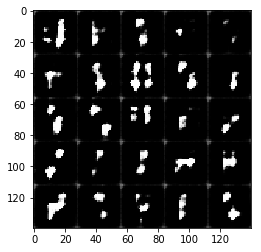

Epoch 1/2... Discriminator Loss: 1.2650... Generator Loss: 0.7439
Epoch 1/2... Discriminator Loss: 0.7250... Generator Loss: 1.4718
Epoch 1/2... Discriminator Loss: 1.9076... Generator Loss: 0.3163
Epoch 1/2... Discriminator Loss: 0.7168... Generator Loss: 1.4165
Epoch 1/2... Discriminator Loss: 1.0203... Generator Loss: 1.1518


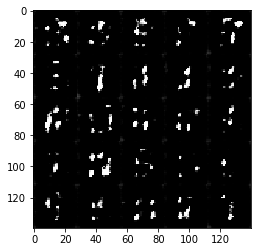

Epoch 1/2... Discriminator Loss: 1.5270... Generator Loss: 0.5343
Epoch 1/2... Discriminator Loss: 0.5968... Generator Loss: 2.5920
Epoch 1/2... Discriminator Loss: 1.5616... Generator Loss: 0.4055
Epoch 1/2... Discriminator Loss: 1.3564... Generator Loss: 0.5852
Epoch 1/2... Discriminator Loss: 1.3602... Generator Loss: 1.4660


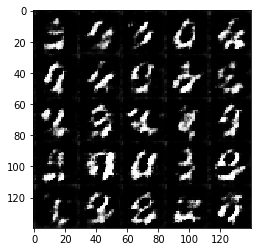

Epoch 1/2... Discriminator Loss: 1.0543... Generator Loss: 1.2511
Epoch 1/2... Discriminator Loss: 1.2200... Generator Loss: 1.3481
Epoch 1/2... Discriminator Loss: 0.8717... Generator Loss: 1.3493
Epoch 1/2... Discriminator Loss: 1.3742... Generator Loss: 1.1515
Epoch 1/2... Discriminator Loss: 1.0281... Generator Loss: 0.8752


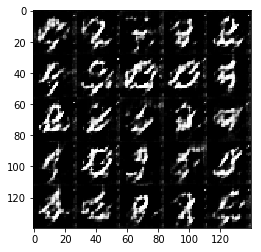

Epoch 1/2... Discriminator Loss: 2.0044... Generator Loss: 2.7568
Epoch 1/2... Discriminator Loss: 0.8784... Generator Loss: 1.3115
Epoch 1/2... Discriminator Loss: 1.0046... Generator Loss: 1.7487
Epoch 1/2... Discriminator Loss: 1.2625... Generator Loss: 0.6414
Epoch 1/2... Discriminator Loss: 1.0695... Generator Loss: 0.9237


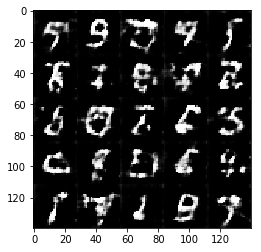

Epoch 1/2... Discriminator Loss: 0.9241... Generator Loss: 1.2113
Epoch 1/2... Discriminator Loss: 1.1777... Generator Loss: 2.7736
Epoch 1/2... Discriminator Loss: 1.1564... Generator Loss: 0.6823
Epoch 1/2... Discriminator Loss: 1.1752... Generator Loss: 0.6729
Epoch 1/2... Discriminator Loss: 0.9094... Generator Loss: 2.1378


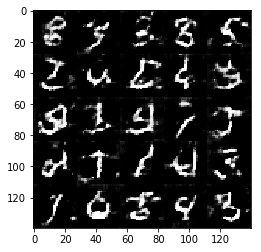

Epoch 1/2... Discriminator Loss: 1.1095... Generator Loss: 1.0742
Epoch 1/2... Discriminator Loss: 0.7864... Generator Loss: 1.3138
Epoch 1/2... Discriminator Loss: 1.0713... Generator Loss: 0.7538
Epoch 1/2... Discriminator Loss: 2.1136... Generator Loss: 0.2397
Epoch 1/2... Discriminator Loss: 1.0608... Generator Loss: 0.8407


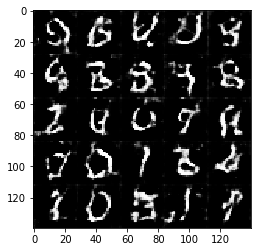

Epoch 1/2... Discriminator Loss: 1.3070... Generator Loss: 0.5877
Epoch 1/2... Discriminator Loss: 0.8370... Generator Loss: 1.4466
Epoch 1/2... Discriminator Loss: 1.1613... Generator Loss: 0.7279
Epoch 1/2... Discriminator Loss: 1.8169... Generator Loss: 0.3829
Epoch 1/2... Discriminator Loss: 2.0872... Generator Loss: 0.2626


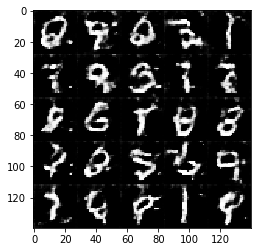

Epoch 1/2... Discriminator Loss: 0.9521... Generator Loss: 1.9526
Epoch 1/2... Discriminator Loss: 0.8555... Generator Loss: 1.1521
Epoch 1/2... Discriminator Loss: 1.4427... Generator Loss: 1.0020
Epoch 1/2... Discriminator Loss: 0.9892... Generator Loss: 1.6297
Epoch 1/2... Discriminator Loss: 0.9052... Generator Loss: 1.0188


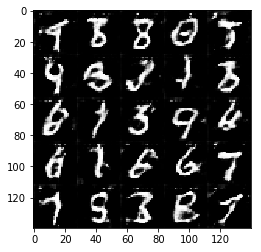

Epoch 1/2... Discriminator Loss: 0.9862... Generator Loss: 0.9753
Epoch 2/2... Discriminator Loss: 1.5008... Generator Loss: 0.6632
Epoch 2/2... Discriminator Loss: 1.2025... Generator Loss: 0.8209
Epoch 2/2... Discriminator Loss: 1.4854... Generator Loss: 0.4693
Epoch 2/2... Discriminator Loss: 0.9817... Generator Loss: 1.3226


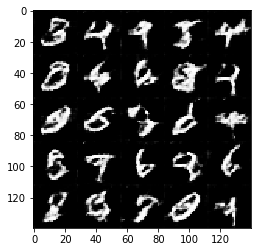

Epoch 2/2... Discriminator Loss: 0.8650... Generator Loss: 1.0373
Epoch 2/2... Discriminator Loss: 1.7860... Generator Loss: 0.3642
Epoch 2/2... Discriminator Loss: 0.8558... Generator Loss: 1.7891
Epoch 2/2... Discriminator Loss: 1.2965... Generator Loss: 0.5927
Epoch 2/2... Discriminator Loss: 2.0241... Generator Loss: 0.3329


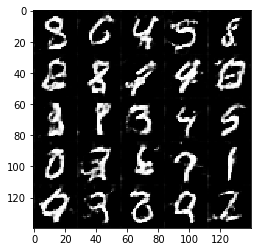

Epoch 2/2... Discriminator Loss: 1.1714... Generator Loss: 0.6845
Epoch 2/2... Discriminator Loss: 0.9053... Generator Loss: 1.0410
Epoch 2/2... Discriminator Loss: 0.8095... Generator Loss: 1.3965
Epoch 2/2... Discriminator Loss: 2.5822... Generator Loss: 0.1579
Epoch 2/2... Discriminator Loss: 0.5667... Generator Loss: 1.8694


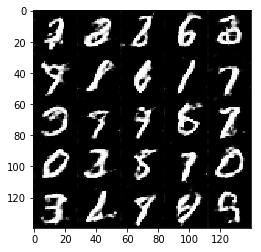

Epoch 2/2... Discriminator Loss: 0.4169... Generator Loss: 3.8296
Epoch 2/2... Discriminator Loss: 0.9957... Generator Loss: 1.5095
Epoch 2/2... Discriminator Loss: 0.9721... Generator Loss: 1.0838
Epoch 2/2... Discriminator Loss: 0.8488... Generator Loss: 1.1439
Epoch 2/2... Discriminator Loss: 0.9676... Generator Loss: 3.7370


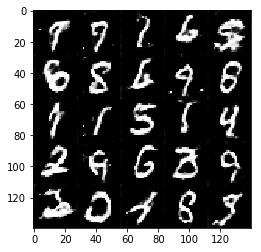

Epoch 2/2... Discriminator Loss: 1.0761... Generator Loss: 1.5450
Epoch 2/2... Discriminator Loss: 0.7971... Generator Loss: 2.3631
Epoch 2/2... Discriminator Loss: 1.0785... Generator Loss: 0.7906
Epoch 2/2... Discriminator Loss: 1.1390... Generator Loss: 0.7984
Epoch 2/2... Discriminator Loss: 0.9795... Generator Loss: 0.8839


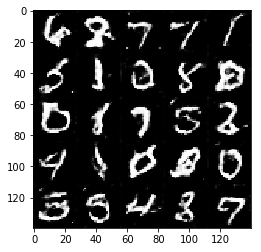

Epoch 2/2... Discriminator Loss: 0.7864... Generator Loss: 1.1684
Epoch 2/2... Discriminator Loss: 1.2429... Generator Loss: 0.7202
Epoch 2/2... Discriminator Loss: 0.9092... Generator Loss: 1.5092
Epoch 2/2... Discriminator Loss: 0.8972... Generator Loss: 1.2381
Epoch 2/2... Discriminator Loss: 1.3486... Generator Loss: 0.5924


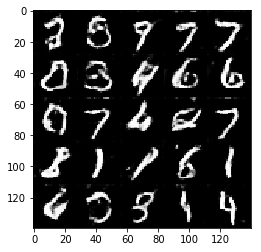

Epoch 2/2... Discriminator Loss: 1.1229... Generator Loss: 0.7696
Epoch 2/2... Discriminator Loss: 0.7917... Generator Loss: 1.3682
Epoch 2/2... Discriminator Loss: 1.0624... Generator Loss: 1.1943
Epoch 2/2... Discriminator Loss: 1.1031... Generator Loss: 0.9697
Epoch 2/2... Discriminator Loss: 2.4054... Generator Loss: 0.2256


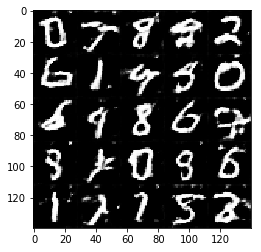

Epoch 2/2... Discriminator Loss: 0.6640... Generator Loss: 1.6411
Epoch 2/2... Discriminator Loss: 1.0758... Generator Loss: 0.8057
Epoch 2/2... Discriminator Loss: 0.9726... Generator Loss: 0.9012
Epoch 2/2... Discriminator Loss: 0.9195... Generator Loss: 1.2709
Epoch 2/2... Discriminator Loss: 1.7317... Generator Loss: 0.3840


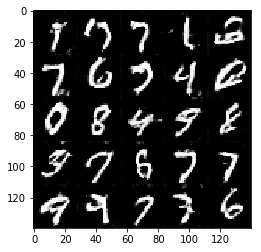

Epoch 2/2... Discriminator Loss: 1.8819... Generator Loss: 3.2364
Epoch 2/2... Discriminator Loss: 0.7760... Generator Loss: 1.6489
Epoch 2/2... Discriminator Loss: 0.7716... Generator Loss: 1.3532
Epoch 2/2... Discriminator Loss: 1.3409... Generator Loss: 2.4129
Epoch 2/2... Discriminator Loss: 1.4095... Generator Loss: 0.6926


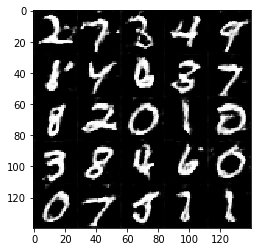

Epoch 2/2... Discriminator Loss: 0.8195... Generator Loss: 1.1546
Epoch 2/2... Discriminator Loss: 0.9923... Generator Loss: 0.9235
Epoch 2/2... Discriminator Loss: 0.7584... Generator Loss: 1.2619


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5206... Generator Loss: 2.1179
Epoch 1/1... Discriminator Loss: 0.7158... Generator Loss: 6.0005
Epoch 1/1... Discriminator Loss: 0.8575... Generator Loss: 2.0278
Epoch 1/1... Discriminator Loss: 0.4957... Generator Loss: 6.7626
Epoch 1/1... Discriminator Loss: 0.3429... Generator Loss: 6.6322


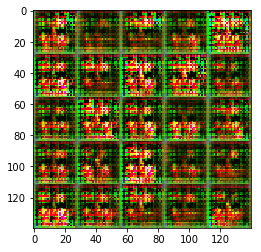

Epoch 1/1... Discriminator Loss: 0.3667... Generator Loss: 4.4796
Epoch 1/1... Discriminator Loss: 0.3944... Generator Loss: 3.5711
Epoch 1/1... Discriminator Loss: 0.3545... Generator Loss: 4.5335
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.9972
Epoch 1/1... Discriminator Loss: 0.7843... Generator Loss: 1.6483


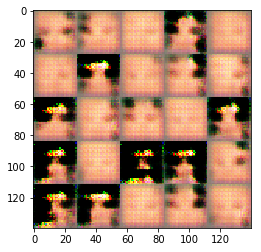

Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 0.7688... Generator Loss: 1.4362
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 1.2680
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 1.2911
Epoch 1/1... Discriminator Loss: 0.7912... Generator Loss: 1.2738


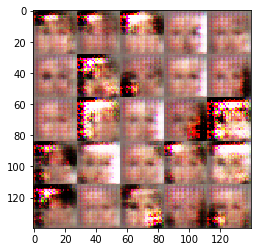

Epoch 1/1... Discriminator Loss: 0.7837... Generator Loss: 1.5242
Epoch 1/1... Discriminator Loss: 0.6843... Generator Loss: 1.7703
Epoch 1/1... Discriminator Loss: 0.7546... Generator Loss: 1.3924
Epoch 1/1... Discriminator Loss: 0.7193... Generator Loss: 1.5999
Epoch 1/1... Discriminator Loss: 0.8661... Generator Loss: 1.4101


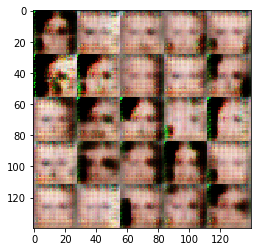

Epoch 1/1... Discriminator Loss: 0.6976... Generator Loss: 1.3784
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 1.5605
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 1.1296
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.7751


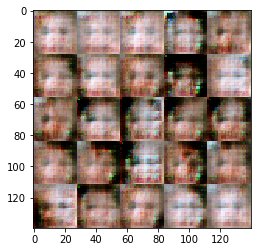

Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 1.0505
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 1.1887


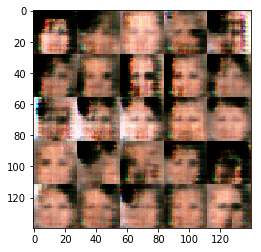

Epoch 1/1... Discriminator Loss: 1.7871... Generator Loss: 2.9791
Epoch 1/1... Discriminator Loss: 2.4794... Generator Loss: 0.1421
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.5192
Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 1.2352
Epoch 1/1... Discriminator Loss: 2.3694... Generator Loss: 3.1616


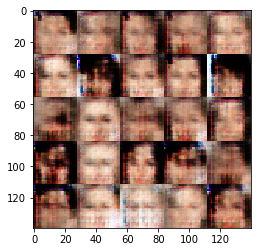

Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.5092
Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 2.0415
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 1.1612
Epoch 1/1... Discriminator Loss: 2.0456... Generator Loss: 0.2186


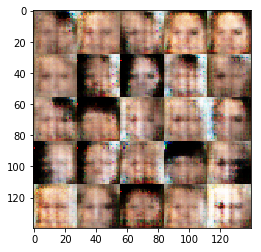

Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 1.2208
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.9556


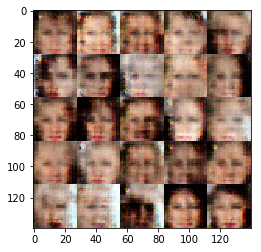

Epoch 1/1... Discriminator Loss: 1.5610... Generator Loss: 2.4109
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.9083
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 1.6667
Epoch 1/1... Discriminator Loss: 0.9458... Generator Loss: 1.2707


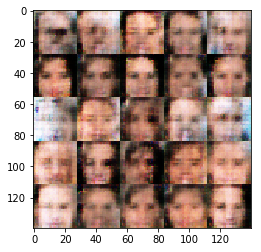

Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 1.2705
Epoch 1/1... Discriminator Loss: 0.8797... Generator Loss: 1.2181
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.9660
Epoch 1/1... Discriminator Loss: 0.8625... Generator Loss: 1.0765


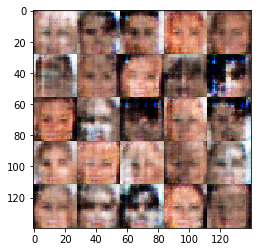

Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.5072
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.5873... Generator Loss: 0.3699
Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 0.9177


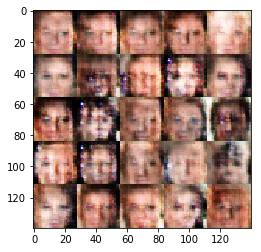

Epoch 1/1... Discriminator Loss: 1.7900... Generator Loss: 2.1495
Epoch 1/1... Discriminator Loss: 1.9517... Generator Loss: 2.0912
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 1.3198
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 0.9944


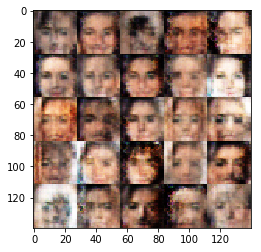

Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.4459
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.5034
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.4825


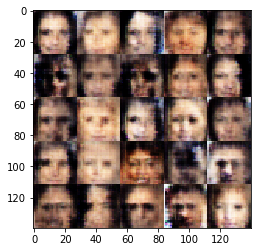

Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 1.0148
Epoch 1/1... Discriminator Loss: 1.6034... Generator Loss: 0.4022
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 1.2122
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 1.1997


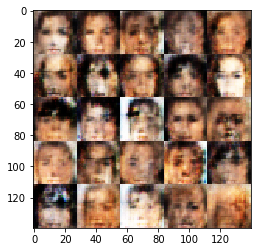

Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 1.1130
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 1.4221
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.5946
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.4449
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 0.8247


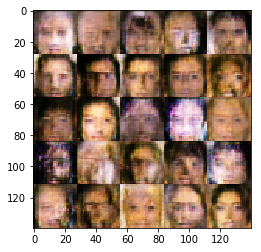

Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.5433
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 1.1452
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 2.0477
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.7708


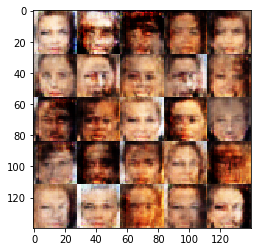

Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.7269... Generator Loss: 2.2767
Epoch 1/1... Discriminator Loss: 2.0783... Generator Loss: 0.2421
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.6410


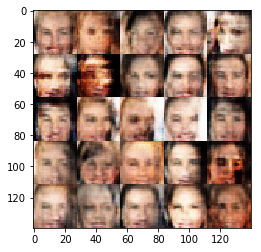

Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 1.6290
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 1.0241
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 1.0078
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.7298


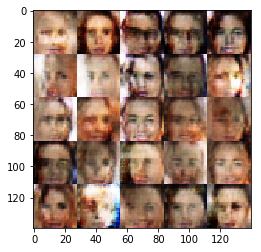

Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 0.9854
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.6133


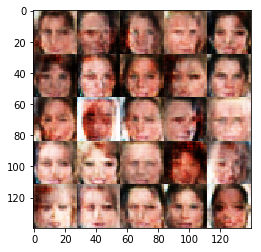

Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.5568
Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 1.3441
Epoch 1/1... Discriminator Loss: 1.5501... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 1.0753


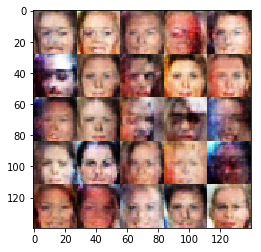

Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.5234
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 1.0348
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 1.6169
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 1.1865


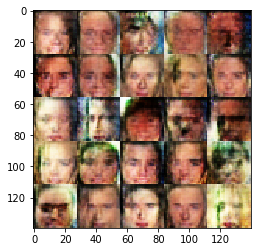

Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 1.2083
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.8785
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 1.2618
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 2.0315


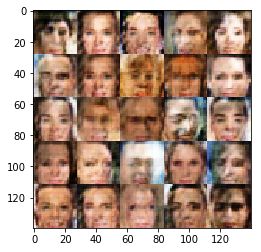

Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.8664


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.